In [27]:
import sage_data_client
import matplotlib.pyplot as plt
import pandas as pd
from metpy.calc import dewpoint_from_relative_humidity, wet_bulb_temperature
from metpy.units import units
from PIL import Image
import numpy as np
import datetime
import act
import glob
import matplotlib
import pyart
import xarray as xr
import numpy as np


from matplotlib.dates import DateFormatter

In [28]:
start = "2023-05-19T00:00:00Z"
end = "2023-05-20T12:00:00Z"

In [29]:
df_temp = sage_data_client.query(start=start,
                                 end=end, 
                                    filter={
                                        "name" : 'wxt.env.temp|wxt.env.humidity|wxt.env.pressure|wxt.rain.accumulation',
                                        "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.23.5.*",
                                        "vsn" : "W08D",
                                        "sensor" : "vaisala-wxt536"
                                    }
)

winds = sage_data_client.query(start=start,
                                 end=end, 
                                    filter={
                                        "name" : 'wxt.wind.speed|wxt.wind.direction',
                                        "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.23.5.*",
                                        "vsn" : "W08D",
                                        "sensor" : "vaisala-wxt536"
                                    }
)


In [30]:
hums = df_temp[df_temp['name']=='wxt.env.humidity']
temps = df_temp[df_temp['name']=='wxt.env.temp']
pres = df_temp[df_temp['name']=='wxt.env.pressure']
rain = df_temp[df_temp['name']=='wxt.rain.accumulation']


npres = len(pres)
nhum = len(hums)
ntemps = len(temps)
nrains = len(rain)
print(npres, nhum, ntemps, nrains)
minsamps = min([nhum, ntemps, npres, nrains])

vals = temps.set_index('timestamp')[0:minsamps]
vals['temperatures'] = vals.value.to_numpy()[0:minsamps]
vals['humidity'] = hums.value.to_numpy()[0:minsamps]
vals['pressure'] = pres.value.to_numpy()[0:minsamps]
vals['rainfall'] = rain.value.to_numpy()[0:minsamps]


direction = winds[winds['name']=='wxt.wind.direction']
speed = winds[winds['name']=='wxt.wind.speed']

nspeed = len(speed)
ndir = len(direction)
print(nspeed, ndir)
minsamps = min([nspeed, ndir])

windy = speed.set_index('timestamp')[0:minsamps]
windy['speed'] = windy.value.to_numpy()[0:minsamps]
windy['direction'] = direction.value.to_numpy()[0:minsamps]


winds10mean = windy.resample('60S').mean(numeric_only=True).ffill()
winds10max = windy.resample('60S').max(numeric_only=True).ffill()

dp = dewpoint_from_relative_humidity( vals.temperatures.to_numpy() * units.degC, 
                                     vals.humidity.to_numpy() * units.percent)

vals['dewpoint'] = dp

vals10 = vals.resample('10S').mean(numeric_only=True).ffill() #ffil gets rid of nans due to empty resample periods


wb = wet_bulb_temperature(vals10.pressure.to_numpy() * units.hPa,
                          vals10.temperatures.to_numpy() * units.degC,
                          vals10.dewpoint.to_numpy() * units.degC)

vals10['wetbulb'] = wb

1564788 1564789 1564789 1564790
1564789 1564791


In [31]:
df_aq = sage_data_client.query(
    start=start,
    end=end, 
    filter={
        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.04.*",
        "vsn": "W08D"
    }
)

pm25 = df_aq[df_aq['name']=='aqt.particle.pm2.5']
pm10 = df_aq[df_aq['name']=='aqt.particle.pm1']
pm100 = df_aq[df_aq['name']=='aqt.particle.pm10']

no = df_aq[df_aq['name']=='aqt.gas.no']
o3 = df_aq[df_aq['name']=='aqt.gas.ozone']
no2 = df_aq[df_aq['name']=='aqt.gas.no2']
co = df_aq[df_aq['name']=='aqt.gas.co']
aqtemp = df_aq[df_aq['name']=='aqt.env.temp']
aqhum = df_aq[df_aq['name']=='aqt.env.humidity']


aqvals = pm25.set_index('timestamp')
aqvals['pm2.5'] = aqvals.value.to_numpy().astype(float)
aqvals['pm1.0'] = pm10.value.to_numpy().astype(float)
aqvals['pm10.0'] = pm100.value.to_numpy().astype(float)

aqvals['no'] = no.value.to_numpy().astype(float)
aqvals['o3'] = o3.value.to_numpy().astype(float)
aqvals['no2'] = no2.value.to_numpy().astype(float)
aqvals['co'] = co.value.to_numpy().astype(float)
aqvals['temp'] =  aqtemp.value.to_numpy().astype(float)
aqvals['hum'] =  aqhum.value.to_numpy().astype(float)


dp = dewpoint_from_relative_humidity( aqvals.temp.to_numpy() * units.degC, 
                                     aqvals.hum.to_numpy() * units.percent)

aqvals['dewpoint'] = dp


(19496.0, 19497.5)

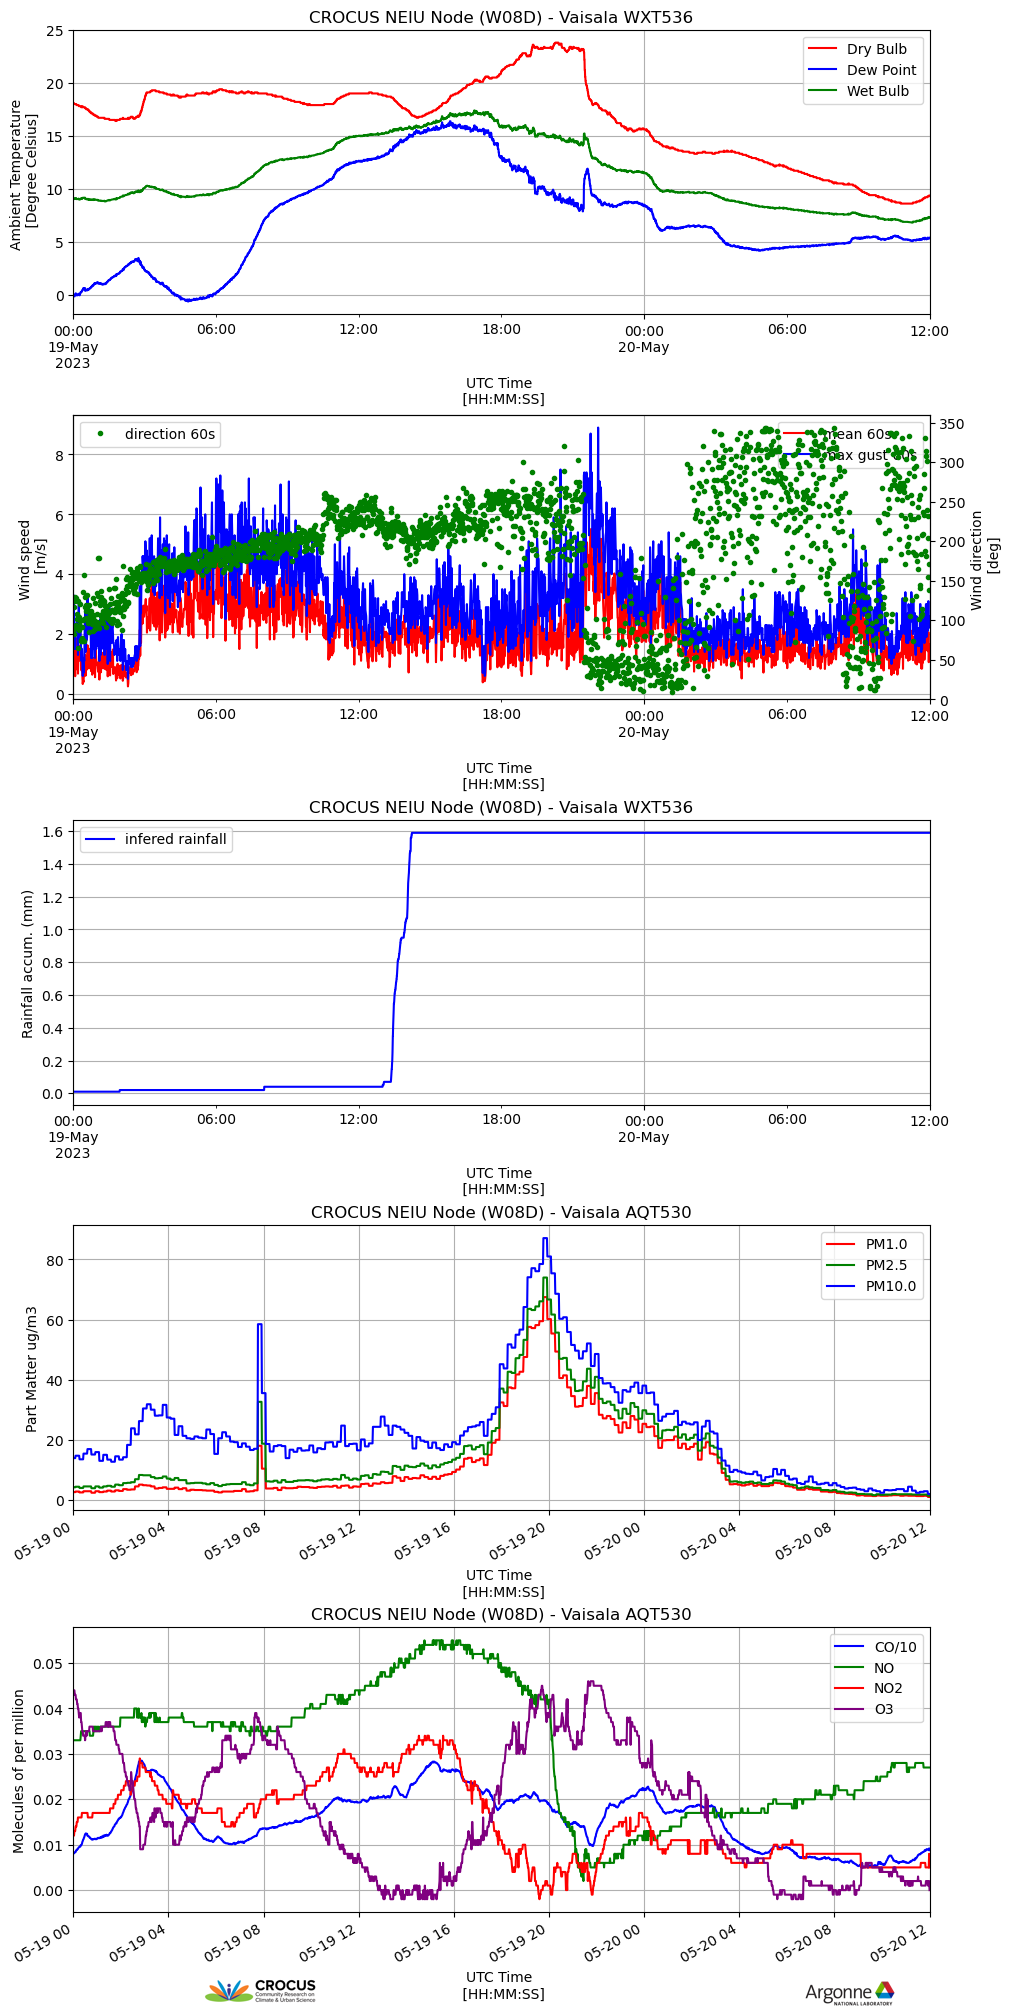

In [32]:
fig, axs = plt.subplots( ncols=1, nrows=5, figsize=[10,20], constrained_layout=True)

vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          ax=axs[0], color='r', label='Dry Bulb',
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                           color='b', label='Dew Point',
                                          ax=axs[0])


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          color='g', label='Wet Bulb',
                                          ax=axs[0])

axs[0].legend()
axs[0].grid(True)

winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='',
                                          ax=axs[1], color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed \n [m/s]',
                                          title='',
                                          ax=axs[1], color='b', label='max gust 60s'
                                          )
axs[1].legend()
axs[1].grid(True)

ytwin = plt.twinx(ax=axs[1])

winds10mean.direction.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind direction \n [deg]',
                                          title='',
                                          ax=ytwin, color='g', label='direction 60s',
                                          marker='.', linestyle='none')

ytwin.legend(loc=2)
ytwin.set_ylim([0,360])
im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)

vals10.rainfall.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Rainfall accum. (mm)',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          ax=axs[2], color='b', label='infered rainfall',
                                          )

axs[2].legend()
axs[2].grid(True)


aqvals['pm1.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[3], color='r', label='PM1.0',
                                          )

aqvals['pm2.5'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[3], color='g', label='PM2.5',
                                          )

aqvals['pm10.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[3], color='b', label='PM10.0',
                                          )

axs[3].legend()
axs[3].grid(True)


(aqvals['co']/10.0).plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='b', label='CO/10',
                                          )

aqvals['no'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='g', label='NO',
                                          )


aqvals['no2'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='r', label='NO2',
                                          )


aqvals['o3'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='purple', label='O3',
                                          )

axs[4].legend()
axs[4].grid(True)

axs[0].set_xlim([start,end])
axs[1].set_xlim([start,end])
axs[2].set_xlim([start,end])
axs[3].set_xlim([start,end])
axs[4].set_xlim([start,end])


In [33]:
files = glob.glob('../data/cl61/cmscl6001_20230519*') + \
        glob.glob('../data/cl61/cmscl6001_20230520*') 
#files = files.append(glob.glob('../data/cl61/cmscl6001_20230520*')) 
#files.append(glob.glob('../data/cl61/cmscl6001_20230521*'))

ds = act.io.read_netcdf(files)
ds['backscatter'] = ds['p_pol']
ds = act.corrections.correct_ceil(ds)


In [34]:
ds['backscatter'] = ds['p_pol']
ds = act.corrections.correct_ceil(ds)

(0.0, 15000.0)

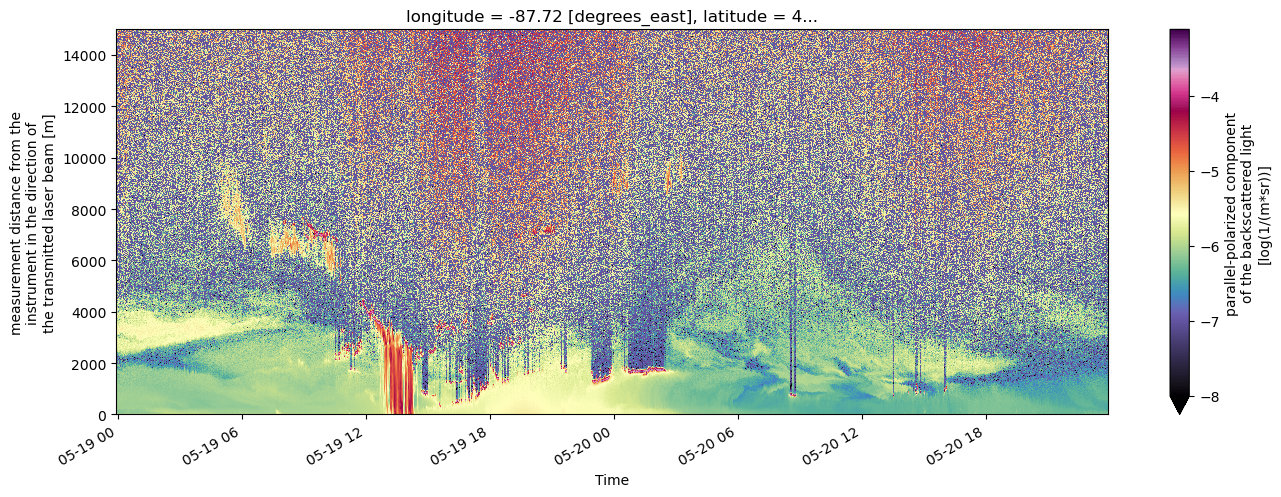

In [35]:
figme = plt.figure(figsize=[16,5])
ds.backscatter.transpose().plot( cmap=pyart.graph.cm_colorblind.ChaseSpectral, vmin = -8)
plt.ylim([0,15000])

(0.0, 15000.0)

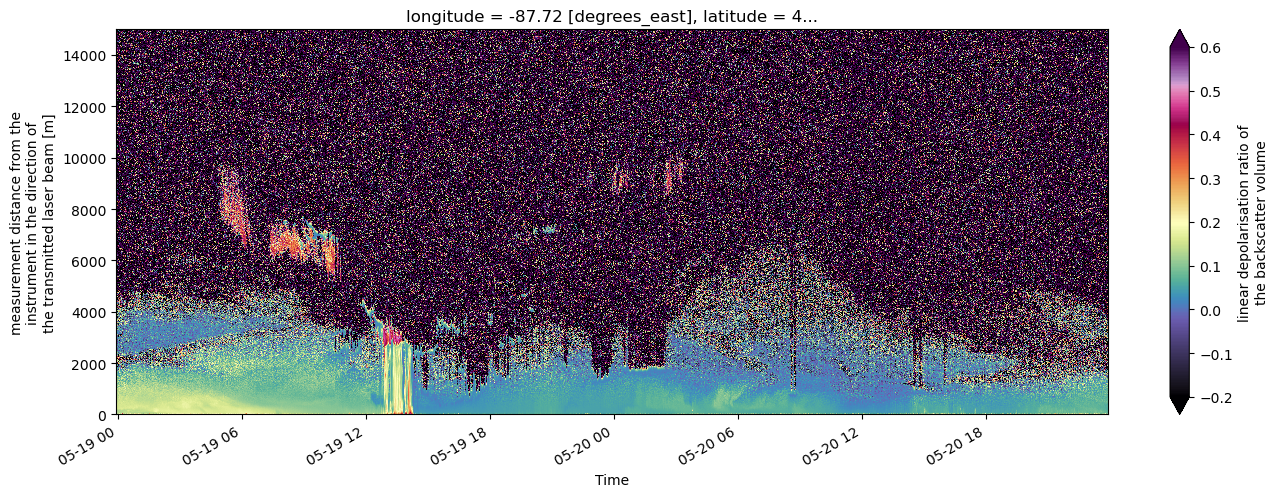

In [36]:
figme = plt.figure(figsize=[16,5])
ds.linear_depol_ratio.transpose().plot( cmap=pyart.graph.cm_colorblind.ChaseSpectral, vmax=.6, vmin=-.2)
plt.ylim([0,15000])

(19496.0, 19497.5)

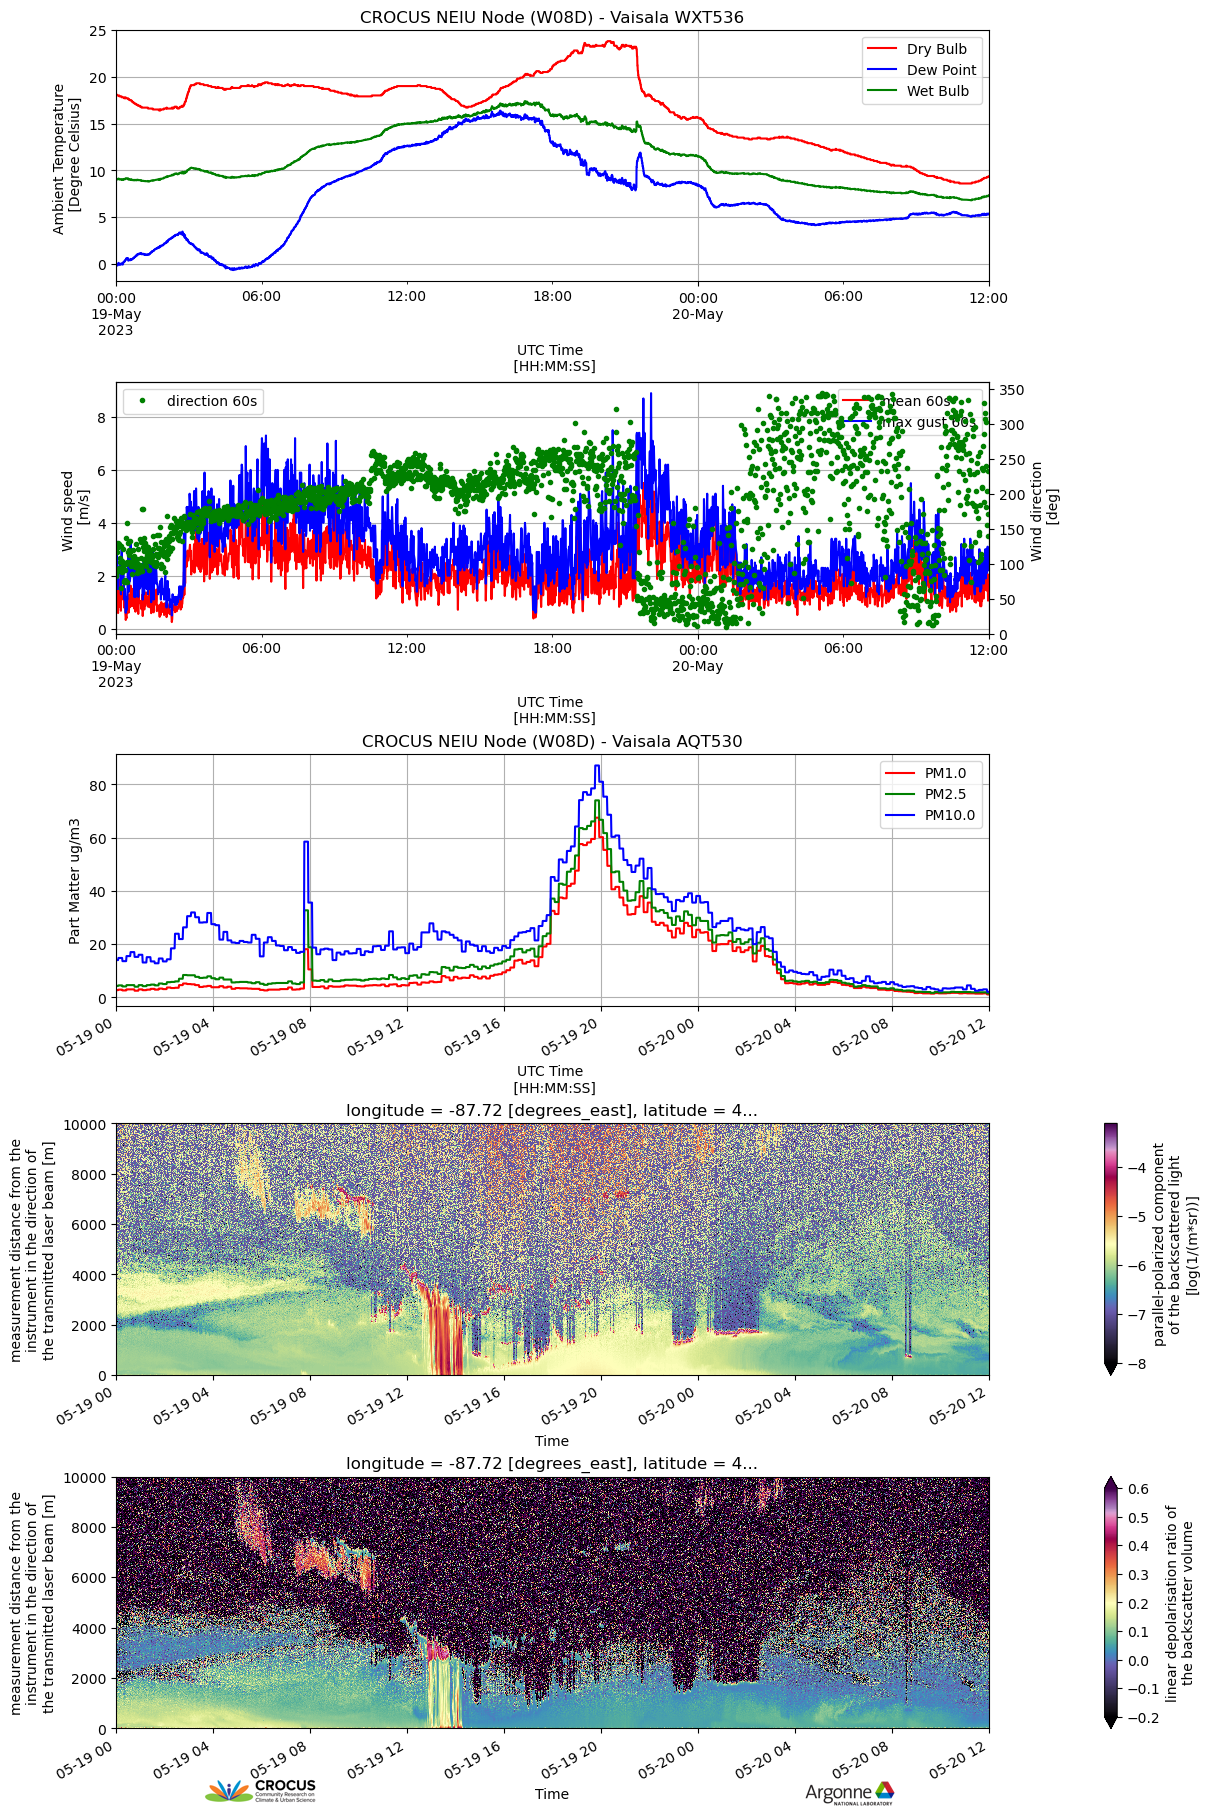

In [43]:

time1 = pd.Timestamp(start)
time2 = pd.Timestamp(end)


fig, axs = plt.subplots( ncols=1, nrows=5, figsize=[12,18], constrained_layout=True)

vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          ax=axs[0], color='r', label='Dry Bulb',
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                           color='b', label='Dew Point',
                                          ax=axs[0])


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          color='g', label='Wet Bulb',
                                          ax=axs[0])

axs[0].legend()
axs[0].grid(True)

winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='',
                                          ax=axs[1], color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed \n [m/s]',
                                          title='',
                                          ax=axs[1], color='b', label='max gust 60s'
                                          )
axs[1].legend()
axs[1].grid(True)

ytwin = plt.twinx(ax=axs[1])

winds10mean.direction.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind direction \n [deg]',
                                          title='',
                                          ax=ytwin, color='g', label='direction 60s',
                                          marker='.', linestyle='none')

ytwin.legend(loc=2)
ytwin.set_ylim([0,360])


aqvals['pm1.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[2], color='r', label='PM1.0',
                                          )

aqvals['pm2.5'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[2], color='g', label='PM2.5',
                                          )

aqvals['pm10.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[2], color='b', label='PM10.0',
                                          )

axs[2].legend()
axs[2].grid(True)

ds.backscatter.transpose().plot( cmap=pyart.graph.cm_colorblind.ChaseSpectral, vmin = -8, ax = axs[3])

ds.linear_depol_ratio.transpose().plot( cmap=pyart.graph.cm_colorblind.ChaseSpectral, vmax=.6, vmin=-.2, ax = axs[4])

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)

axs[3].set_ylim([0,10000])
axs[4].set_ylim([0,10000])

axs[0].set_xlim([start,end])
axs[1].set_xlim([start,end])
axs[2].set_xlim([start,end])
axs[3].set_xlim([time1, time2])
axs[4].set_xlim([time1, time2])



In [45]:
ds.to_netcdf('/Users/scollis/smokey_CL61.nc')

In [46]:
print('h')

h
